In [84]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import cvxpy as cp
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn')

/var/folders/4m/rxd9grt91hq7n4__bqp6nkvr0000gn/T/ipykernel_3450/1659410565.py:7: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


In [85]:
df_ori = pd.read_csv('./close.csv', sep=',')
df_ori.head()

,Date,AAPL,AMZN,JNJ,JPM,LLY,MSFT,NVDA,PG,UNH,XOM
0,2003-11-18,0.364464,2.4250,51.939999,34.889999,70.940002,25.150000,1.639167,47.830002,24.549999,35.150002
1,2003-11-19,0.364643,2.4765,52.259998,34.759998,72.540001,25.350000,1.685000,48.040001,25.790001,35.439999
2,2003-11-20,0.363929,2.4425,51.490002,34.630001,71.529999,25.100000,1.640000,47.705002,25.400000,35.310001
3,2003-11-21,0.362143,2.4290,50.880001,35.000000,69.610001,25.110001,1.646667,47.880001,25.860001,35.340000
4,2003-11-24,0.377679,2.5665,51.480000,35.270000,70.500000,25.730000,1.745833,48.310001,26.400000,35.560001


In [86]:
df_ori.set_index('Date', inplace=True)
df_ori.index = pd.DatetimeIndex(df_ori.index)
# df.head()

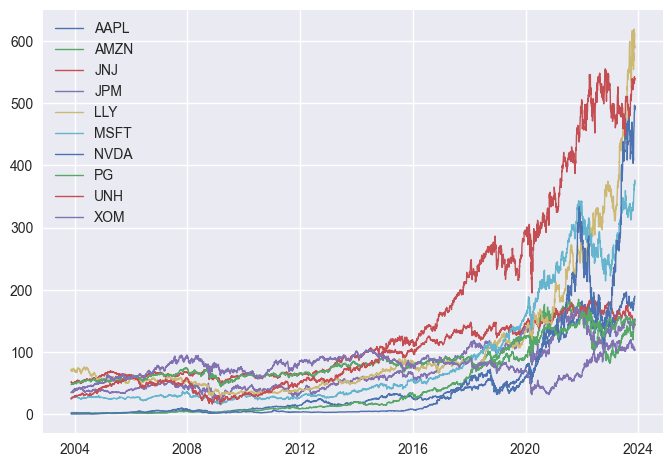

In [87]:
plt.figure()
for stk in df_ori.columns:
    plt.plot(df_ori.index, df_ori.loc[:,stk], linewidth=1, label=stk)
    plt.legend(loc='best')

plt.show()

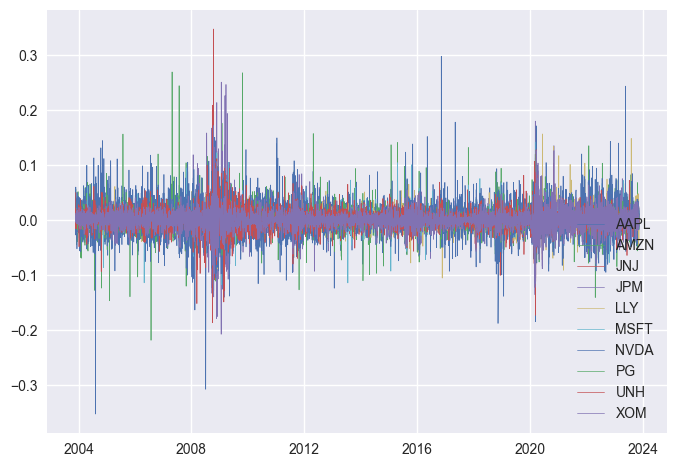

In [88]:
df = df_ori.pct_change().iloc[1:,:]

plt.figure()
for stk in df.columns:
    plt.plot(df.index, df.loc[:,stk], linewidth=0.5, label=stk)
    plt.legend(loc='best')

plt.show()

In [89]:
initial_stg = [1/len(df.columns)] * len(df.columns)
initial_stg

[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]

In [90]:
def OGD(x_old, ETA, loss):
    # x = cp.Variable(10, nonneg=True)
    x = cp.Variable(10, nonneg=False)
    objective = cp.Minimize(ETA * np.array(loss) @ x + 0.5 * cp.sum((x - x_old) ** 2))
    constraints = [cp.sum(x) == 1]
    prob = cp.Problem(objective, constraints)
    result = prob.solve(solver=cp.ECOS)

    return x.value

In [91]:
# begin OGD process
arr_pfl = [1]
cur_pfl = 1
cur_stg = np.array(initial_stg.copy())
ETA = 0.05

for i in range(len(df)):
    # return of today
    cur_pfl = cur_pfl * np.dot(cur_stg, 1 + df.iloc[i,:].values)
    # print(cur_pfl)
    arr_pfl.append(cur_pfl)
    # define the loss
    loss = -1 * df.iloc[i,:].values.copy()
    # OGD to find strategy in the next round
    cur_stg = OGD(cur_stg, ETA, loss)
    # print(cur_stg)

In [92]:
def equally_weighted(df):
    arr_pfl = [1]
    cur_pfl = 1
    cur_stg = np.array([1 / len(df.columns)] * len(df.columns))

    for i in range(len(df)):
        cur_pfl = cur_pfl * np.dot(cur_stg, 1 + df.iloc[i,:].values)
        arr_pfl.append(cur_pfl)

    return arr_pfl

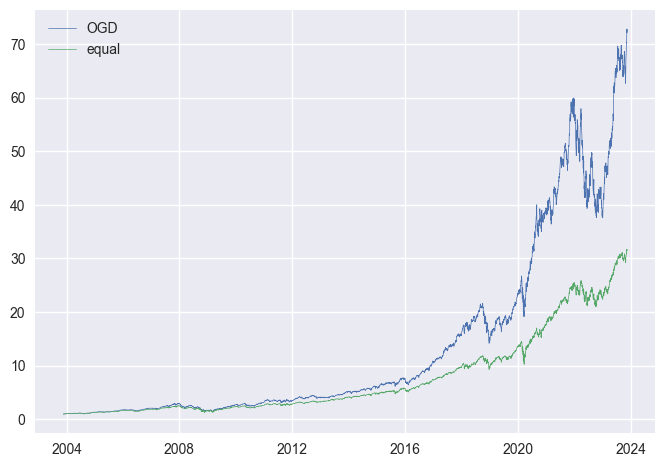

In [93]:
plt.figure()
plt.plot(df.index, arr_pfl[:-1], linewidth=0.5, label='OGD')
plt.plot(df.index, equally_weighted(df)[:-1], linewidth=0.5, label='equal')
plt.legend(loc='best')
plt.show()

In [94]:
cur_stg

array([ 0.27366652,  0.18520817, -0.02506889,  0.04617618,  0.04391023,
        0.07789211,  0.31249087, -0.01886843,  0.10746228, -0.00286904])